# <center> Organizacion de datos </center>
#### <center> Curso Rodriguez </center>
## <center> Trabajo practico I: Reservas de Hotel </center>
#### <center> Integrantes del grupo: </center>

<center>

| Apellido y nombre | Padron |
| - | - |
| Ayala, Camila | 107440 |
| Loscalzo, Melina | 106571 |
| Masri, Noah | 108814 |

</center>

# Checkpoint 4: Redes Neuronales

- Construir una red neuronal para clasificación y mejorar su performance la búsqueda de arquitectura e hiperparámetros adecuados.
- Evaluar la performance de todos los modelos en entrenamiento y validación,
explicar todas las métricas y mostrar la matriz de confusión.
- Generar predicciones con el conjunto de test y realizar los submits
correspondientes en la competencia de Kaggle.
- Generar las conclusiones finales del trabajo práctico evaluando la performance
de todos los modelos entrenados.

# Preparacion

Comenzamos como siempre, importando las librerias que vamos a usar

In [61]:
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [62]:
import pandas as pd
import numpy as np
import pickle

#Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Nadam
import keras_tuner as kt

import sklearn as sk
from sklearn.model_selection import KFold,StratifiedKFold,RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, make_scorer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

En segundo lugar, importamos el dataset con el que vamos a estar trabajando; el dataset ya trabajado en el checkpoint 1

In [63]:
ds = pd.read_csv("https://drive.google.com/uc?export=download&id=1HuOWp-SuBRQrokZkpEWEz2kaloWOJqiR")

Generamos una copia de este para no alterar sus datos originales.

In [64]:
ds_redes_neuronales = ds.copy()

Tal como en la parte anterior, seleccionamos las columnas que no consideramos importantes, y las quitamos. El criterio fue explicado ya en el checkpoint 2.

In [65]:
to_drop = ['country', 'reservation_status_date', 'stays_in_weekend_nights', 'arrival_date_year', 'arrival_date_day_of_month', 'id','assigned_room_type', 'days_in_waiting_list', 'company']
ds_redes_neuronales.drop(to_drop, axis = 'columns', inplace = True)

# Funciones utiles

In [66]:
def pasar_prediccion_a_binario(y):
  umbral = 0.5  # Umbral para la conversión binaria
  y_pred_binario = np.where(y >= umbral, 1, 0)  # Convertir las predicciones continuas a binarias
  return y_pred_binario

Para esta entrega se pide realizar una variedad de modelos de prediccion, y para cada uno de ellos, evaluar su performance en los conjuntos de entrenamiento y validación, explicar todas las métricas y mostrar la matriz de confusión. Dado que esto se pide para todos, creamos una funcion que imprima la matriz de confusion y las metricas dado el x e y de un dataset, para poder llamarla con cada modelo tanto para el set de entrenamiento como para el de testeo.

In [67]:
def mostrarPerformance (model, x, y):
  y_pred = model.predict(x)
  y_pred_binario = pasar_prediccion_a_binario(y_pred)
  cm = confusion_matrix(y,y_pred_binario)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

  print(classification_report(y,y_pred_binario))
  print('F1-Score: {}'.format(f1_score(y, y_pred_binario, average='binary')))

Creamos otra funcion que separa nuestro dataset en un conjunto de entrenamiento y testeo. No lo hacemos una sola vez generalizado ya que para algunos modelos podrian ser mas o menos relevantes ciertas columnas o habria q hacerle un trabajo previo, mientras que quizas para otros no.

In [68]:
# El test size es un parametro adicional, pero que por defecto tiene asignado 0.3
def separarConjuntos(ds, test_size=0.3): 
    
    # Creo un dataset con los features que voy a usar para clasificar
    ds_x = ds.drop(['is_canceled'], axis='columns', inplace=False)

    # Creo un dataset con la variable target
    ds_y = ds['is_canceled'].copy()

    # Genero los conjuntos de train y de test
    return train_test_split(ds_x, ds_y, test_size=test_size, random_state=2)


## para llamarla x_train, x_test, y_train, y_test = separarConjuntos(ds, test_size)

Esta otra funcion realiza el hot-encoding que usamos para deshacernos de variables categoricas, lo cual es necesario para realizar algunos modelos.
Aplicamos a algunas esto, mientras que a otras que no nos 
resultan tan relevantes las mapeamos a diversos valores. Resulta natural el mapeo del tipo de habitacion pues habiamos notado un patron de orden en los precios.

In [69]:
def ds_con_one_hot_encoding(ds):
  ds = pd.get_dummies(ds, columns=["hotel","deposit_type","customer_type", "market_segment"], drop_first=True)

  ds['meal'] = ds['meal'].map({'BB' : 0, 'FB': 1, 'HB': 2, 'SC': 3, 'Undefined': 4})

  ds['distribution_channel'] = ds['distribution_channel'].map({'Direct': 0, 'Corporate': 1, 'TA/TO': 2, 'Undefined': 3,
                                                                        'GDS': 4})

  ds['reserved_room_type'] = ds['reserved_room_type'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6,
                                                                    'H': 7, 'L': 8, 'P':9})

  ds['agent'] = ds['agent'].replace('No_agent', 0)
  ds['agent'] = ds['agent'].astype(float)

  return ds

Como vamos a querer visualizar la pérdida de entrenamiento y prueba a lo largo de las épocas del entrenamiento de nuestro modelo, generamos esta funcion que recibe el diccionario del historial generado durante el entrenamiento y realiza dicho grafico. La pérdida es una medida de qué tan bien nuestro modelo está realizando las predicciones durante el entrenamiento.

In [70]:
def visualizacion_perdida(history):
  # Obtener los valores de pérdida de entrenamiento y prueba del historial
  train_loss = history.history['loss']
  test_loss = history.history['val_loss']

  plt.figure(figsize=(10, 5))
  plt.plot(train_loss, label='Training Loss', color='#185fad')
  plt.plot(test_loss, label='Testing Loss', color='orange')
  plt.title('Perdida en entrenamiento y test en base a las epocas', fontsize=20)
  plt.xlabel('Epoch', fontsize=11)
  plt.ylabel('Perdida', fontsize=11)
  plt.legend(fontsize=11)
  plt.show()

# El modelo

En primer lugar, vamos a aplicar one hot encoding a nuestras variables ya que al estar aplicando funciones matematicas, es logico que estos modelos no las acepten.

In [71]:
ds_redes_neuronales = ds_con_one_hot_encoding(ds_redes_neuronales)

Luego, separamos el dataset en train y test, usando nuestra funcion. En primer lugar, elegimos usar unicamente el 20% de los datos para testeo, y el resto para entrenamiento.

In [72]:
x_train, x_test, y_train, y_test = separarConjuntos(ds_redes_neuronales, 0.2)

Ahora, escalamos los datos para achicar la varianza de estos.

In [73]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## Modelo basico

Creamos el modelo vacio, sin agregarle ninguna capa de activacion

In [ ]:
model = Sequential()

Agregamos como unica capa oculta, una con 64 neuronas, y con funcion de activacion softmax. Luego en la capa de salida elegimos la funcion de activacion sigmoidea, acorde a nuestro problema. Elegimos como numero de salidas 1 ya que asi es la naturaleza de nuestro problema.

In [ ]:
model.add(Dense(64, activation='softmax'))
model.add(Dense(1, activation='sigmoid'))

Compilamos ahora el modelo usando entropia cruzada categorica, la cual penaliza fuertemente las predicciones incorrectas, y recompensa las correctas, lo que hace que converja, pero podria sobreajustar, por lo que debemos prestarle atencion. Elegimos como optimizador Adam, ya que es uno de los mas utilizados, y como metrica accuracy, ya que al estar nuestro data set bastante balanceado, es una metrica representativa.

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Entrenamos finalmente el modelo con un tamano de batch size de 256, ya que nuestro dataset es lo suficientemente grande para poder usar un numero elevado, ademas de que en general se usan potencias de 2, por lo que probaremos con este.

In [ ]:
cant_epochs=500
history_model=model.fit(x_train, y_train, epochs=cant_epochs, batch_size=256, verbose=False)

Ahora, haremos predicciones con nuestro modelo.

387/387 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0       0.79      0.83      0.81      6178
           1       0.83      0.78      0.80      6187

    accuracy                           0.81     12365
   macro avg       0.81      0.81      0.81     12365
weighted avg       0.81      0.81      0.81     12365

F1-Score: 0.8016295310941137


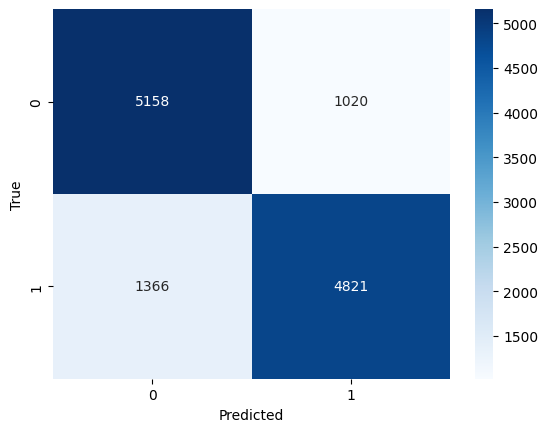

In [ ]:
mostrarPerformance(model, x_test, y_test)

1546/1546 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

           0       0.80      0.85      0.83     24732
           1       0.84      0.79      0.82     24727

    accuracy                           0.82     49459
   macro avg       0.82      0.82      0.82     49459
weighted avg       0.82      0.82      0.82     49459

F1-Score: 0.8172204492835241


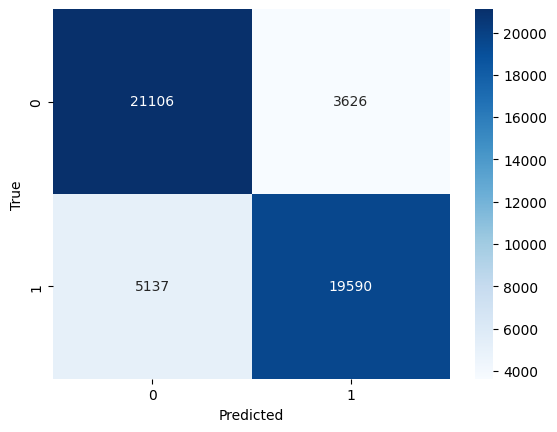

In [ ]:
mostrarPerformance(model, x_train, y_train)

Vemos que las metricas obtenidas con una sola capa no son tan terribles, ni tampoco parece haber mucho sobreajuste. Intentaremos mejorarlas variando epochs, agregando capas, etc.

In [ ]:
filename = "rnbasico.pickle"

# save model
pickle.dump(model, open(filename, "wb"))

## Una capa oculta con regulador L1


Creamos un nuevo modelo secuencial, ahora con una capa de entrada y 1 oculta, ambas con funcion de activacion relu, y una de salida con funcion de activacion sigmoidea. Tomamos en la primera capa 20 neuronas, en la segunda un poco mas, y en la ultima tomamos una sola, ya que es binaria nuestra clasificacion. Agregamos a su vez en la ultima capa un regulador L1, para intentar reducir el sobreajuste.

In [ ]:
model = keras.Sequential([
    Dense(20, activation='relu', input_shape=(len(ds_redes_neuronales.columns)-1,)),
    Dense(50, activation='relu'),    
    Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l1(0.01)),
])


Compilamos nuestro usando la misma funcion de perdida, la misma metrica, pero cambiando el optimizador. Elegimos Nadam ya que es muy parecido a Adam, solo que mas sofisticado, ya que usa la correccion de Nesterov y suele llevar a una convergencia mas rapida.


In [ ]:
opt = keras.optimizers.Nadam(learning_rate=0.01)
model.compile(
    optimizer=opt,
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

Entrenamos al modelo

In [ ]:
history = model.fit(x_train, y_train, epochs=500, batch_size=256, verbose=False)

387/387 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.78      0.85      0.82      6178
           1       0.84      0.77      0.80      6187

    accuracy                           0.81     12365
   macro avg       0.81      0.81      0.81     12365
weighted avg       0.81      0.81      0.81     12365

F1-Score: 0.8001349869231418


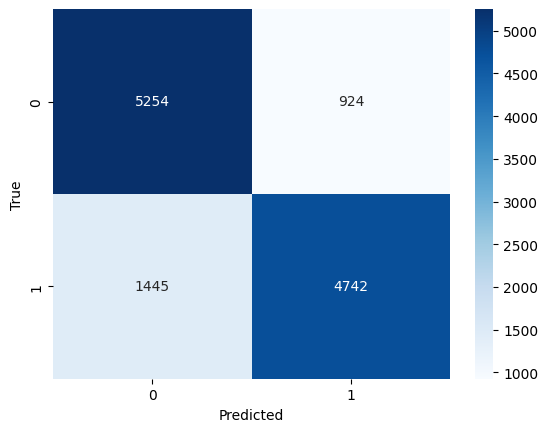

In [ ]:
mostrarPerformance(model, x_test, y_test)

1546/1546 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

           0       0.79      0.86      0.83     24732
           1       0.85      0.78      0.81     24727

    accuracy                           0.82     49459
   macro avg       0.82      0.82      0.82     49459
weighted avg       0.82      0.82      0.82     49459

F1-Score: 0.8104194372321787


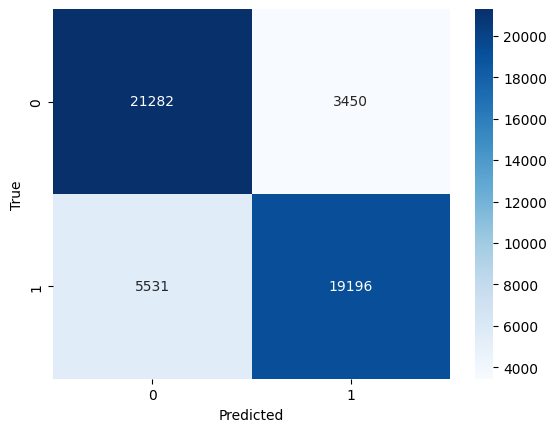

In [ ]:
mostrarPerformance(model, x_train, y_train)

Vemos que, a pesar de que esta sobreajustando un poco los datos, las metricas obtenidas en el set de entrenamiento son buenas. Igualmente, no superan a las metricas obtenidas con el modelo mas basico de todos. Veremos si podemos mejorarlo un poco.

Generamos un grafico para ver que tan buena es su accuracy, en relacion a la cantidad de epocas

In [ ]:
epochs = range(500)
plt.figure(figsize=(10, 6))
plt.plot(epochs, history.history['accuracy'], color='orange', label='Accuracy')
plt.title("Accuracy respecto de las epochs")
plt.xlabel("Cantidad de epocas")
plt.ylabel("Accuracy")
plt.show()

Vemos que dicha funcion sigue una forma cuasi logaritmica, con ciertas variaciones. Se observa que en valores un poco mas pequenos de epocas hay valores casi iguales o incluso mejores.

In [ ]:
max_accuracy = max(history.history['accuracy'])
max_epoch = history.history['accuracy'].index(max_accuracy) + 1

print("Max Accuracy: {:.4f} at Epoch: {}".format(max_accuracy, max_epoch))

Max Accuracy: 0.8190 at Epoch: 354


Volvemos a entrenar a nuestro modelo usando el epoch que optimiza nuestro accuracy.

In [ ]:
history = model.fit(x_train, y_train, epochs=max_epoch, batch_size=256, verbose=False)

387/387 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.79      0.84      0.82      6178
           1       0.83      0.78      0.80      6187

    accuracy                           0.81     12365
   macro avg       0.81      0.81      0.81     12365
weighted avg       0.81      0.81      0.81     12365

F1-Score: 0.8037726400133546


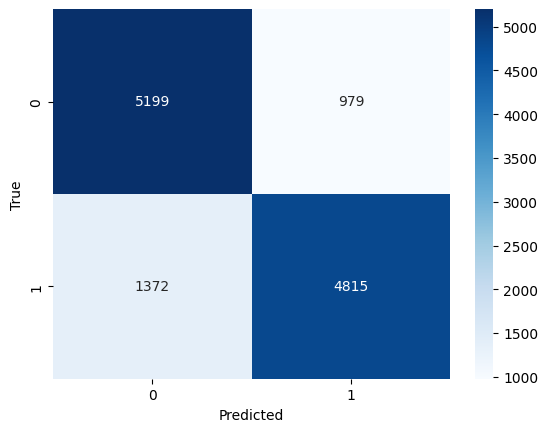

In [ ]:
mostrarPerformance(model, x_test, y_test)

1546/1546 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

           0       0.80      0.85      0.83     24732
           1       0.84      0.79      0.81     24727

    accuracy                           0.82     49459
   macro avg       0.82      0.82      0.82     49459
weighted avg       0.82      0.82      0.82     49459

F1-Score: 0.8145208455175871


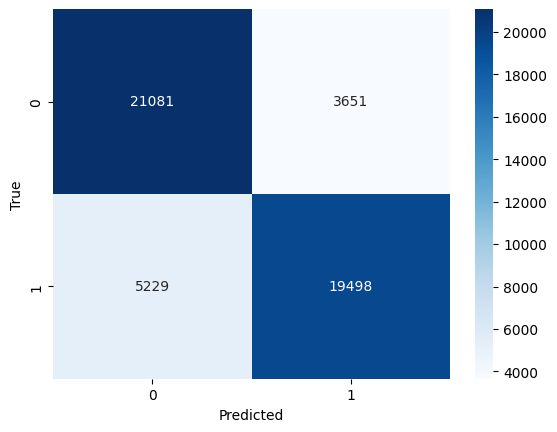

In [ ]:
mostrarPerformance(model, x_train, y_train)

Vemos que ahora las metricas mejoraron dos milesimas respecto del modelo mas basico, sobreajustando un poco menos, y con un tiempo de ejecucion menor. Veremos igualmente si mediante otras tecnicas logramos reducir mas el sobreajuste y mejorar las metricas. 

In [ ]:
filename = "rn_epochs_opt"

# save model
pickle.dump(model, open(filename, "wb"))

## Una capa oculta con Early Stopping

Creamos un nuevo modelo secuencial, con una unica capa oculta. En este modelo decidimos aumentar el número de neuronas en las capas, y agregarle un early stopping, ya que 500 epocas nos parecia demasiado, y posiblemente no sean necesarias.


In [74]:
# Crear la estructura del modelo
model = Sequential()
input_shape = (len(ds_redes_neuronales.columns) - 1,)  
model.add(Dense(128, activation='relu', input_shape=input_shape))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', patience=10) 

Usamos lo mismo que en el modelo anterior.

In [75]:
# Compilar el modelo
model.compile(loss='bce',
              optimizer='nadam',
              metrics=['binary_accuracy'])

Entrenamos entonces al modelo. A pesar de que ponemos 1000 epocas, esperamos que con el Early Stopping la ejecucion se detenga mucho antes.

In [76]:
# Entrenar el modelo
history = model.fit(x_train, y_train, epochs=1000, batch_size=256, validation_data=(x_test, y_test), callbacks=[es], verbose=False)

Generamos el grafico de perdida a lo largo de las epocas

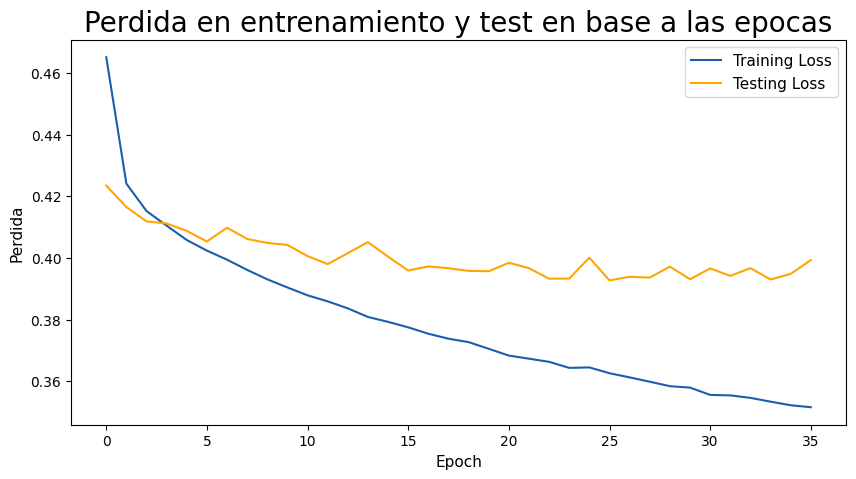

In [77]:
visualizacion_perdida(history)

Ahora, haremos predicciones con nuestro modelo.

387/387 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0       0.77      0.89      0.82      6178
           1       0.87      0.73      0.79      6187

    accuracy                           0.81     12365
   macro avg       0.82      0.81      0.81     12365
weighted avg       0.82      0.81      0.81     12365

F1-Score: 0.794631107991929


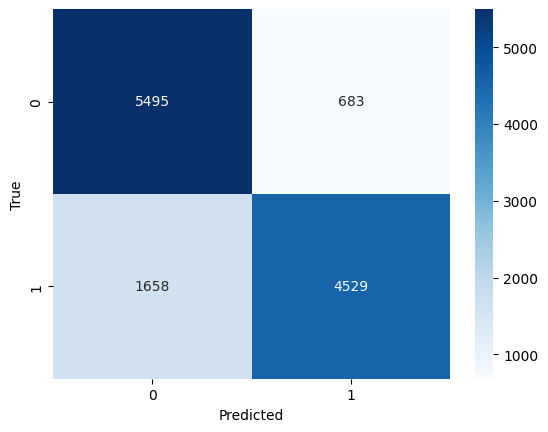

In [78]:
mostrarPerformance(model, x_test, y_test)

1546/1546 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

           0       0.78      0.91      0.84     24732
           1       0.89      0.75      0.82     24727

    accuracy                           0.83     49459
   macro avg       0.84      0.83      0.83     49459
weighted avg       0.84      0.83      0.83     49459

F1-Score: 0.8155079626578804


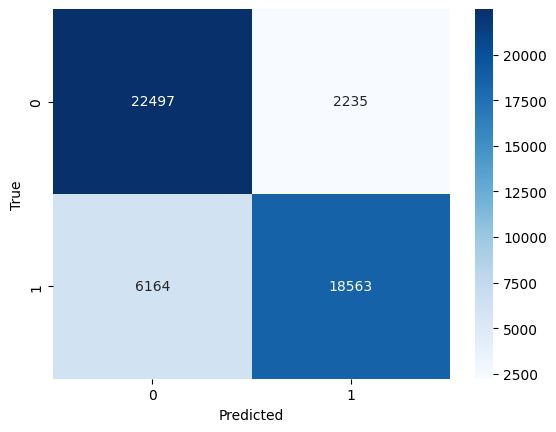

In [79]:
mostrarPerformance(model, x_train, y_train)

In [80]:
# Scoring
train_score = model.evaluate(x_train,y_train,verbose=1)
test_score = model.evaluate(x_test,y_test,verbose=1)
labels = model.metrics_names

print('')
print(f'Training Accuracy: {train_score[1]}')
print(f'Testing Accuracy: {test_score[1]}')

387/387 [==============================] - 1s 2ms/step - loss: 0.3993 - binary_accuracy: 0.8107

Training Accuracy: 0.8301825523376465
Testing Accuracy: 0.8106752634048462


Si bien las metricas son buenas sobre ambos conjuntos, en test vemos que estas son mas bajas, por lo que hay un sobrajuste, a pesar de intentar evitarlo mediante early stopping.

In [81]:
filename = "rn_earlystop.pickle"

# save model
pickle.dump(model, open(filename, "wb"))

## Una capa oculta con Dropout

Creamos un nuevo modelo secuencial. Ahora, en vez de usar el metodo de regulacion Early Stopping, realizamos un dropout por cada capa, variando el porcentaje a apagar en base a la cantidad de neuronas.

In [95]:
model = Sequential()
input_shape = (len(ds_redes_neuronales.columns) - 1,)
model.add(Dense(128, activation='relu', input_shape=input_shape))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

Contnuamos usando accuracy como metrica, para mantener un criterio en comun entre los diversos modelos.

In [96]:
opt = keras.optimizers.Nadam(learning_rate=0.01)
model.compile(loss='bce',
              optimizer=opt,
              metrics=['binary_accuracy'])

 Al usar early stopping en el modelo anterior, el modelo freno el entrenamiento en una cantidad de epocas rondando las 40. Deseaba ver como se comporta en las siguientes, por lo cual lo entrenamos con 150 epocas. 

In [97]:
history = model.fit(x_train, y_train, epochs=150, batch_size=256,validation_data=(x_test, y_test), verbose=False)

Hacemos uso de nuestra funcion para visualizar las perdidas

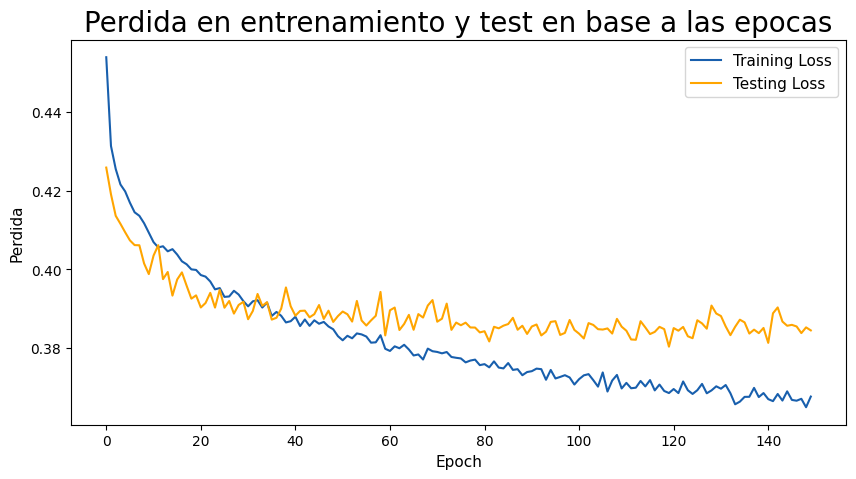

In [98]:
visualizacion_perdida(history)

Del grafico se puede observar que la cantidad maxima de epocas resultante de usar early stopping es coherente con la evolucion de la perdida de la entropia binaria cruzada. Luego de las 40 epocas vemos que vuelve a reducirse, pero no sigue un patron muy marcado sino que tiene diversos picos en ciertas epocas aleatorias. 

Ahora, haremos predicciones con nuestro modelo.

387/387 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0       0.78      0.88      0.83      6178
           1       0.87      0.75      0.80      6187

    accuracy                           0.81     12365
   macro avg       0.82      0.81      0.81     12365
weighted avg       0.82      0.81      0.81     12365

F1-Score: 0.8010425716768028


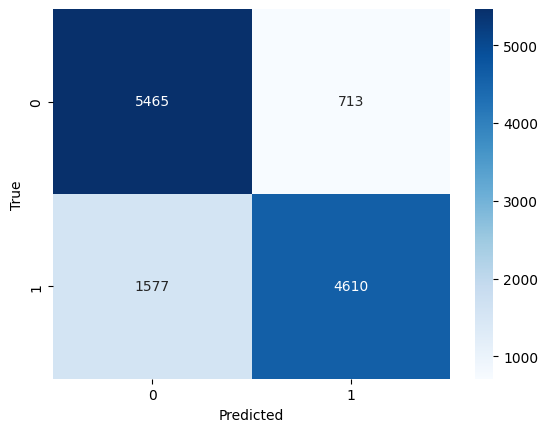

In [99]:
mostrarPerformance(model, x_test, y_test)

1546/1546 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

           0       0.79      0.90      0.84     24732
           1       0.89      0.77      0.82     24727

    accuracy                           0.83     49459
   macro avg       0.84      0.83      0.83     49459
weighted avg       0.84      0.83      0.83     49459

F1-Score: 0.8215681166970565


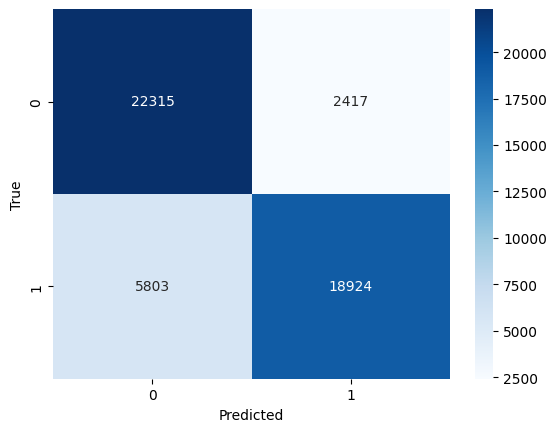

In [100]:
mostrarPerformance(model, x_train, y_train)

Vemos que las metricas no han mejorado y que ademas sigue sobreajustando tanto como en el anterior

In [101]:
# Scoring
train_score = model.evaluate(x_train,y_train,verbose=1)
test_score = model.evaluate(x_test,y_test,verbose=1)
labels = model.metrics_names

print('')
print(f'Training Accuracy: {train_score[1]}')
print(f'Testing Accuracy: {test_score[1]}')

387/387 [==============================] - 1s 1ms/step - loss: 0.3845 - binary_accuracy: 0.8148

Training Accuracy: 0.8338017463684082
Testing Accuracy: 0.8147998452186584


Podemos observar que el modelo esta haciendo un pequeno sobreajuste sobre los datos de entrenamiento.

In [102]:
filename = "rn_dropout"

# save model
pickle.dump(model, open(filename, "wb"))

## Una capa oculta con Early Stopping y dropout

Al correr los modelos anteriores, vimos que tendian ambos al sobreajuste. Aunque en el segundo caso haya sido menor, decidimos crear un nuevo modelo con Early Stopping y drop out, a ver si podiamos minimizarlo.

In [ ]:
model = Sequential()
input_shape = (len(ds_redes_neuronales.columns) - 1,)  # Asegurar que input_shape sea una tupla
model.add(Dense(100, activation='relu', input_shape=input_shape))
model.add(Dropout(0.18))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
                  optimizer=Nadam(learning_rate=0.01),
                  metrics=['accuracy'])

Creamos el Early Stopping, con paciencia 10.

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=10) 

Compilamos el modelo como las otras veces, con nadam.

In [ ]:
# Compilar el modelo
model.compile(loss='bce',
              optimizer='nadam',
              metrics=['binary_accuracy'])

Entrenamos el modelo, esta veces usando un batchsize menor que en las anteriores.

In [ ]:
# Entrenar el modelo
history = model.fit(x_train, y_train, epochs=1000, batch_size=128, validation_data=(x_test, y_test), callbacks=[es], verbose=False)

Visualizamos su funcion de perdida

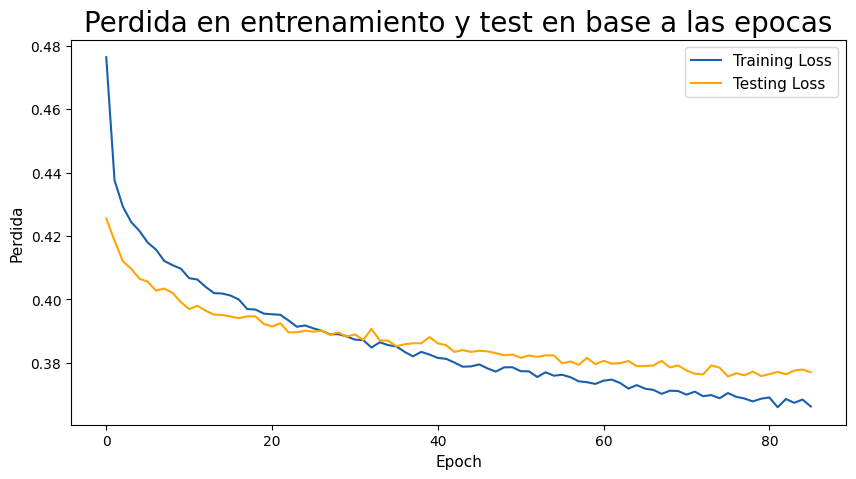

In [ ]:
visualizacion_perdida(history)

387/387 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.80      0.85      0.83      6178
           1       0.84      0.79      0.82      6187

    accuracy                           0.82     12365
   macro avg       0.82      0.82      0.82     12365
weighted avg       0.82      0.82      0.82     12365

F1-Score: 0.8152409538102385


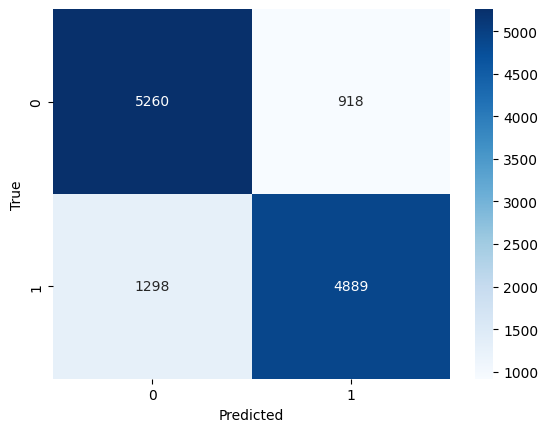

In [ ]:
mostrarPerformance(model, x_test, y_test)

1546/1546 [==============================] - 3s 2ms/step
              precision    recall  f1-score   support

           0       0.82      0.87      0.84     24732
           1       0.86      0.81      0.83     24727

    accuracy                           0.84     49459
   macro avg       0.84      0.84      0.84     49459
weighted avg       0.84      0.84      0.84     49459

F1-Score: 0.8306159042575372


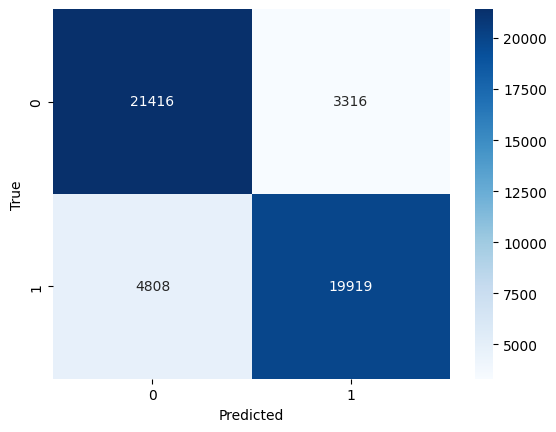

In [ ]:
mostrarPerformance(model, x_train, y_train)

Este modelo fue rapido de correr, y las metricas mejoraron levemente, por lo que consideramos que hasta el momento, este fue nuestro mejor modelo.

In [ ]:
filename = "rn_earlystop_dropout.pickle"

# save model
pickle.dump(model, open(filename, "wb"))

## Modelo Final optimizado con K-Folds


Una capa de entrada, una oculta, 1 de salida y dropout. Creamos una funcion que genera el modelo, con un learning rate especifico para el output, y luego buscamos optimizar este, la cantidad de epocas y los batches con KFolds.

In [ ]:
# Definimos la funcion para crear el modelo
def create_model(learning_rate=0.01):
    model = Sequential()
    # Configura las capas y parámetros de tu modelo
    input_shape = (len(ds_redes_neuronales.columns) - 1,)  # Asegurar que input_shape sea una tupla
    model.add(Dense(64, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.18))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.15))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer=Nadam(learning_rate=learning_rate),
                  metrics=['accuracy'])

    return model


Epoch 1/75


<ipython-input-21-880ec697fff1>:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model)


Se han truncado las últimas 5000 líneas del flujo de salida.
1237/1237 [==============================] - 3s 3ms/step - loss: 0.5843 - accuracy: 0.6420
Epoch 70/75
1237/1237 [==============================] - 4s 3ms/step - loss: 0.5788 - accuracy: 0.6484
Epoch 71/75
1237/1237 [==============================] - 4s 3ms/step - loss: 0.5913 - accuracy: 0.6493
Epoch 72/75
1237/1237 [==============================] - 3s 3ms/step - loss: 0.5765 - accuracy: 0.6511
Epoch 73/75
1237/1237 [==============================] - 3s 3ms/step - loss: 0.5774 - accuracy: 0.6494
Epoch 74/75
1237/1237 [==============================] - 3s 3ms/step - loss: 0.6061 - accuracy: 0.6500
Epoch 75/75
310/310 [==============================] - 1s 2ms/step
Epoch 1/75
1237/1237 [==============================] - 5s 3ms/step - loss: 0.6335 - accuracy: 0.6399
Epoch 2/75
1237/1237 [==============================] - 4s 3ms/step - loss: 0.6249 - accuracy: 0.6085
Epoch 3/75
1237/1237 [==============================] - 3s 3ms

Generamos el modelo con el learning rate que pusimos por defecto

In [ ]:
model = KerasClassifier(build_fn=create_model)

Generamos una grilla con los parametros que queremos probar, y definimos la metrica a optimizar.

In [ ]:
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'epochs': [50, 75, 100],
    'batch_size': [32, 64, 128]
}

scoring = make_scorer(accuracy_score)

Creamos el objeto kfolds, con 5 folds, y entrenamos el random search con nuestra grilla.

In [ ]:
kf = KFold(n_splits=5) 
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=kf, scoring=scoring, n_iter=10)
random_search.fit(x_train, y_train)

# Obtiene los mejores resultados y la mejor combinación de parámetros
best_score = random_search.best_score_
best_params = random_search.best_params_

print("Mejor puntuación:", best_score)
print("Mejores parámetros:", best_params)

# Entrena un nuevo modelo utilizando los mejores parámetros encontrados
best_learning_rate = best_params['learning_rate']
best_epochs = best_params['epochs']
best_batch_size = best_params['batch_size']

model = create_model(learning_rate=best_learning_rate)
model.fit(x_train, y_train, epochs=best_epochs, batch_size=best_batch_size)

# Evalúa el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Pérdida en el conjunto de prueba:", test_loss)
print("Precisión en el conjunto de prueba:", test_accuracy)


387/387 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0       0.78      0.88      0.83      6178
           1       0.87      0.75      0.81      6187

    accuracy                           0.82     12365
   macro avg       0.82      0.82      0.82     12365
weighted avg       0.82      0.82      0.82     12365

F1-Score: 0.8063234277816173


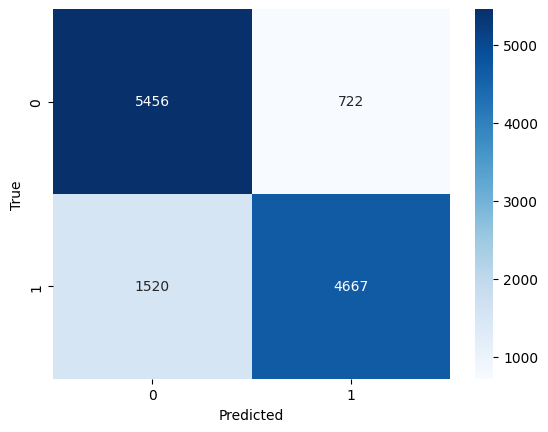

In [ ]:
mostrarPerformance(model, x_test, y_test)

1546/1546 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

           0       0.79      0.89      0.84     24732
           1       0.87      0.76      0.81     24727

    accuracy                           0.83     49459
   macro avg       0.83      0.83      0.82     49459
weighted avg       0.83      0.83      0.82     49459

F1-Score: 0.8140562681901475


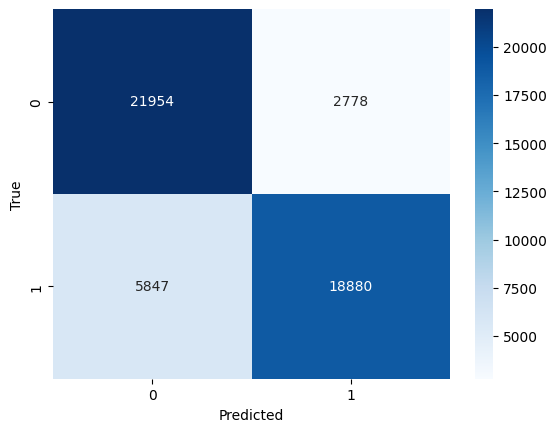

In [ ]:
mostrarPerformance(model, x_train, y_train)

Concluimos que no vale la pena generar y esperar las 4 horas que tarda esta ejecucion, cuando nuestro modelo mas basico obtuvo metricas muy similares. De todas formas nos guardamos el modelo.

In [ ]:
filename = "red_neuronal_kfolds"

# save model
pickle.dump(model, open(filename, "wb"))

Entrenamos al modelo

In [ ]:
# Scoring
train_score = model.evaluate(x_train,y_train,verbose=1)
test_score = model.evaluate(x_test,y_test,verbose=1)
labels = model.metrics_names

print('')
print(f'Training Accuracy: {train_score[1]}')
print(f'Testing Accuracy: {test_score[1]}')

387/387 [==============================] - 1s 1ms/step - loss: 0.3768 - accuracy: 0.8189

Training Accuracy: 0.836147129535675
Testing Accuracy: 0.8189243674278259


La precisión en el conjunto de entrenamiento fue de aproximadamente 0.82029 y la precisión en el conjunto de prueba fue de aproximadamente 0.8149. Estos valores indican que el modelo tiene un rendimiento similar en ambos conjuntos de datos, lo que sugiere que no hay un sobreajuste (overfitting) significativo en este caso.

In [ ]:
filename = "rn5.pickle"

# save model
pickle.dump(model, open(filename, "wb"))

# Preparacion del dataset para realizar predicciones

In [103]:
#importamos el conjunto de test real y le hacemos una copia
ds = pd.read_csv('https://drive.google.com/uc?export=download&id=1L-GDEKGbwtLMdYKCxhrJ9m4HZ5NIr5i2', index_col=None)

ds_copy = ds.copy()
#hacemos sobre este el mismo trabajo que hicimos con el de entrenamiento
ds_x_test = ds_con_one_hot_encoding(ds_copy)
ds_x_test.fillna(0, inplace=True)
ds_x_test.drop(to_drop, axis = 'columns', inplace = True)

# Definimos el diccionario que asigna un número a cada mes
diccionario_meses = {
  'january': '1',
  'february': '2',
  'march': '3',
  'april': '4',
  'may': '5',
  'june': '6',
  'july': '7',
  'august': '8',
  'september': '9',
  'october': '10',
  'november': '11',
  'december': '12'
}

# Definimos la función que convierte un nombre de mes en su número correspondiente
def mes_a_numero(mes):
  if pd.isna(mes):
    return mes
  elif mes.lower() in diccionario_meses:
    return diccionario_meses[mes.lower()]
  else:
    return mes

# Aplicamos la funcion y convertimos los numeros a enteros en vez de strings
ds_x_test['arrival_date_month'] = ds_x_test['arrival_date_month'].apply(mes_a_numero).astype(int)

In [104]:
ds_scaled = scaler.transform(ds_x_test)
y = model.predict(ds_scaled)
y_bin = pasar_prediccion_a_binario(y)
y_pred = pd.DataFrame(y_bin, columns=['is_canceled'])

830/830 [==============================] - 1s 1ms/step


In [105]:
ds_submission = pd.DataFrame({'id': ds['id'], 'is_canceled': y_pred['is_canceled']})

Finalmente exportamos nuestras predicciones ya listas para publicar.

In [107]:
ds_submission.to_csv('red_neuronal_do.csv', index=False)
